In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
from scipy import linalg, stats, ndimage
from scipy.sparse import diags

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':10})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [4]:
import ldfa.ldfa as ldfa

# load data and EDA

In [32]:
data_dir = "../data"
file_name = ['v4_lfp_beta.npy', 'pfc_lfp_beta.npy']
rec_time = [0, 0.5]

In [33]:
data = [np.load('%s/%s'%(data_dir, f)) for f in file_name]

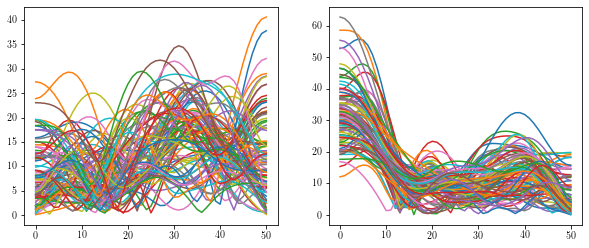

In [34]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1); plt.plot(data[0][0].T)
plt.subplot(1,2,2); plt.plot(data[1][0].T)
plt.show()

In [35]:
data[0].shape, data[1].shape

((1000, 96, 51), (1000, 96, 51))

In [10]:
maps = io.loadmat('../data/maps.mat')
maps = [maps['maps'][0][0][1], maps['maps'][0][0][0]]

In [11]:
coordinates = np.array(np.divmod(np.argsort(np.reshape(maps,(2,-1)), axis=1)[:,:-4], 10)).transpose(1,0,2)

In [12]:
grid_x, grid_y = np.mgrid[0:10:100j,0:10:100j]

# tuning parameters
## preset parameters from EDA

In [13]:
dims = [data[0].shape[1], data[1].shape[1]]
num_time = data[0].shape[2]
num_trial = data[0].shape[0]
num_f = 10

In [14]:
offset_cross = 10; offset_auto = 10
lambda_auto = 0.0; lamda_aug = 0.3

## cross-validation

In [15]:
# candidate parameters
lambdas = [2e-5, 2e-4, 2e-3, 2e-2, 2e-1,2]
num_factors = [5,10, 15, 20, 25, 30, 35, 40]

In [16]:
# CV takes long, we skip it here
# AICs = np.zeros(len(num_factors))
# BICs = np.zeros(len(num_factors))
# for fi in range(len(num_factors)):
#     num_f = num_factors[fi]
#     loglikes = cross_validate(data, num_f, lambdas)
#     maxi = np.argmax(loglikes)
#     lambda_cross = lambdas[maxi]
#     print(num_f, ' factors CV results: ', loglikes)
#     print('picking: ', lambda_cross)
#     Pi, Rho, params = ldfa.est(
#         data, num_f, lambda_cross, offset_cross, lambda_auto, offset_auto,
#         make_pd=True)
#     AICs[fi] = ldfa.AIC(data, params)
#     BICs[fi] = ldfa.BIC(data, params)

In [17]:
# CV result
lambda_cross = 0.02
num_f = 10

## estimate

In [18]:
Pi, Rho, params = ldfa.fit(
    data, num_f, lambda_cross, offset_cross, lambda_auto, offset_auto)

# result

In [19]:
Sigma0 = np.linalg.inv(params['Omega'])

Text(0, 0.5, '$ \\Vert \\Sigma_f \\Vert_F^2 $')

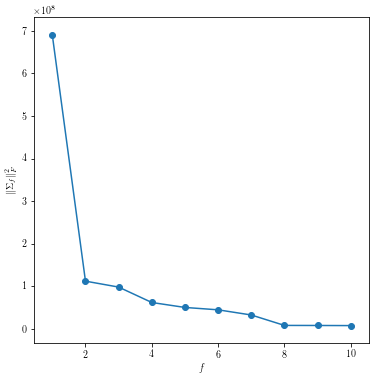

In [20]:
# figure showing amplitude for each factor characterized by Frobenius Norm
amplitude = np.sum(Sigma0**2, (-1, -2)) 

plt.figure(figsize=(6,6))
plt.plot(np.arange(num_f)+1,np.sort(amplitude)[::-1])
plt.scatter(np.arange(num_f)+1,np.sort(amplitude)[::-1])
plt.xlabel(r'$f$')
plt.ylabel(r'$ \Vert \Sigma_f \Vert_F^2 $')

In [21]:
indices = np.argsort(amplitude)[:-4:-1]
LFSs = np.log10(amplitude)

In [22]:
b_time = np.linspace(rec_time[0], rec_time[1], num_time)
l_time = np.linspace(rec_time[0], rec_time[1], 2*num_time-1)

In [23]:
beta_sign = [np.sign(np.sum(b, 0)) for b in params['beta']]

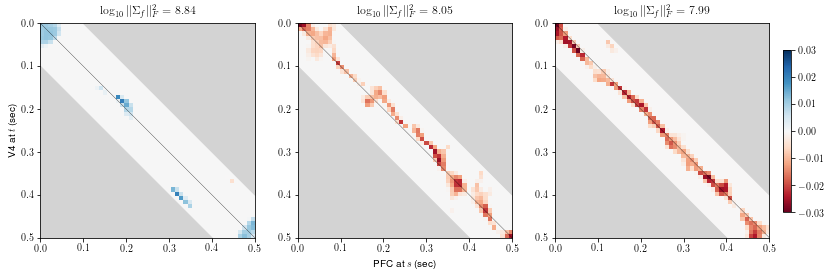

In [24]:
fig = plt.figure(figsize=(15,4))
for i, (P, lfs, s1, s2) in enumerate(zip(Pi[indices], LFSs[indices], beta_sign[0][indices], beta_sign[1][indices])):
    ax = plt.subplot(1,3,i+1)
    ldfa.imshow(s1 * s2 * P[:num_time,num_time:]
               *(np.abs(np.arange(num_time) - np.arange(num_time)[:,None]) < offset_cross-1), 
               time=rec_time, identity=True)
    plt.title(r"$\log_{10} \|\Sigma_f\|_F^2 = %.2f$"%lfs)
    
    plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
    plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
    plt.clim(-0.03, 0.03)
    
fig.subplots_adjust(right=0.8)
    
# add a big axis, hide frame
ax3 = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax3.set_ylim(rec_time)
ax3.set_ylabel("V4 at $t$ (sec)")
ax3.set_xlabel("PFC at $s$ (sec)")

ax_cb = fig.add_axes([0.77, 0.15, 0.05, 0.7])
ax_cb.axis('off')
cb = plt.colorbar(ax.get_images()[0], ticks=[-0.03, -0.02, -0.01, 0, 0.01, 0.02, 0.03])
# cb.ax.set_yticklabels(['-0.04','-0.02','0.00','0.02','0.04'])

In [25]:
sigma = 1
weights = np.exp(-np.sum(np.square(
    np.mgrid[0:10:100j,0:10:100j][...,None]-coordinates[0][:,None,None,:]),
    0) / (2*sigma**2))

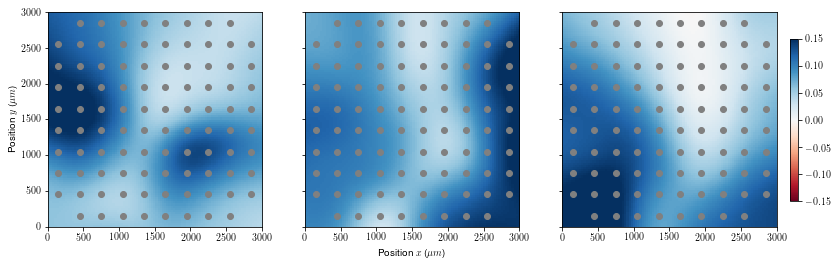

In [26]:
from scipy.interpolate import griddata
fig, axes = plt.subplots(1,3, figsize=(15,4), sharex=True, sharey=True)
for ax, b, s in zip(axes, params['beta'][0][:,indices].T, beta_sign[0][indices]):
    plt.sca(ax)
    ldfa.imshow((np.sum(weights*b*s,-1)/np.sum(weights,-1)).T, 
                origin='lower', extent=(0,3000,0,3000))
    plt.plot(coordinates[0,0]*300+150, coordinates[0,1]*300+150,
             'o', color='gray')
    plt.clim(-0.15, 0.15)
    
fig.subplots_adjust(right=0.8)
    
# add a big axis, hide frame
ax3 = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax3.set_ylim(0, 3000)
ax3.set_ylabel(r"Position $y$ ($\mu m$)")
ax3.set_xlabel(r"Position $x$ ($\mu m$)")

ax_cb = fig.add_axes([0.77, 0.15, 0.05, 0.7])
ax_cb.axis('off')
cb = plt.colorbar(ax.get_images()[0], ticks=[-0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15])
# cb.ax.set_yticklabels(['-0.04','-0.02','0.00','0.02','0.04'])

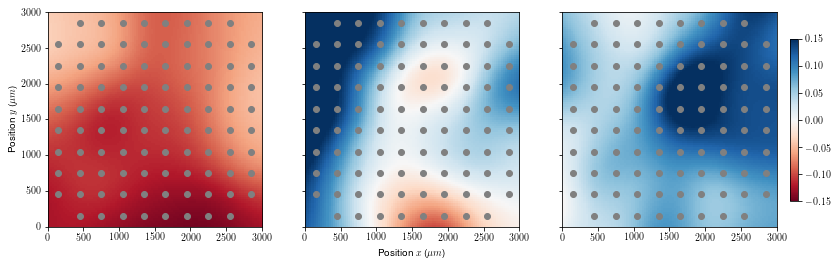

In [27]:
from scipy.interpolate import griddata
fig, axes = plt.subplots(1,3, figsize=(15,4), sharex=True, sharey=True)
for ax, b, s in zip(axes, params['beta'][1][:,indices].T, beta_sign[0][indices]):
    plt.sca(ax)
    ldfa.imshow((np.sum(weights*b*s,-1)/np.sum(weights,-1)).T, 
                origin='lower', extent=(0,3000,0,3000))
    plt.plot(coordinates[0,0]*300+150, coordinates[0,1]*300+150,
             'o', color='gray')
    plt.clim(-0.15, 0.15)
    
fig.subplots_adjust(right=0.8)
    
# add a big axis, hide frame
ax3 = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax3.set_ylim(0, 3000)
ax3.set_ylabel(r"Position $y$ ($\mu m$)")
ax3.set_xlabel(r"Position $x$ ($\mu m$)")

ax_cb = fig.add_axes([0.77, 0.15, 0.05, 0.7])
ax_cb.axis('off')
cb = plt.colorbar(ax.get_images()[0], ticks=[-0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15])
# cb.ax.set_yticklabels(['-0.04','-0.02','0.00','0.02','0.04'])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


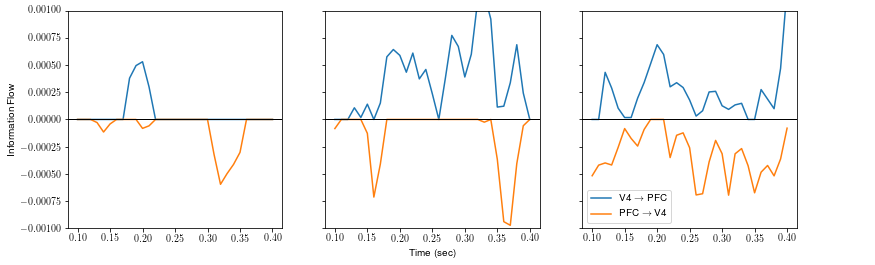

In [28]:
#figure showing information flow in the main body
from scipy import ndimage
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,4))

for ax, Rho_f, Pi_f in zip(axes, Rho[indices], Pi[indices]):
    times = np.arange(num_time)*0.01
    pc_cross = Pi_f[:num_time, num_time:]
    
    lead_lag1 = np.mean(np.abs(np.minimum(0,
            (np.arange(num_time)>np.arange(num_time)[:,None])
            *pc_cross)),0)
    lead_lag2 = np.mean(np.abs(np.minimum(0,
            (np.arange(num_time)<np.arange(num_time)[:,None])
            *pc_cross)),0)
    
#     for i in range(num_time):
#         lead_lag[i] = np.mean((times-i>0)*np.abs(np.minimum(0,cross[i,:])))
#         lead_lag2[i] = np.mean((times-i<0)*np.abs(np.minimum(0,cross[i,:])))

    sigma = 2
    x_g1d = times # ndimage.gaussian_filter1d(times, sigma)
    y_g1d = lead_lag1 # ndimage.gaussian_filter1d(lead_lag1, sigma)
    y_g1d2 = lead_lag2 # ndimage.gaussian_filter1d(lead_lag2, sigma)

    #plt.rcParams.update({'font.size': 28})
    ax.plot(x_g1d[10:num_time-10],y_g1d[10:num_time-10], label=r"V4 $\rightarrow$ PFC")
    ax.plot(x_g1d[10:num_time-10],-y_g1d2[10:num_time-10], label=r"PFC $\rightarrow$ V4")
    ax.axhline(y=0, color='black', linewidth=1)
    ax.set_ylim([-0.001,0.001])
    #plt.legend(['V4-PFC', 'PFC-V4'])

fig.subplots_adjust(right=0.8)
ax.legend()
    
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
plt.ylim([-0.001,0.001])
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Time (sec)")
plt.ylabel("Information Flow")

ax_cb = fig.add_axes([0.8, 0.15, 0.06, 0.7], frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

Text(0, 0.5, 'Partial $R^2$')

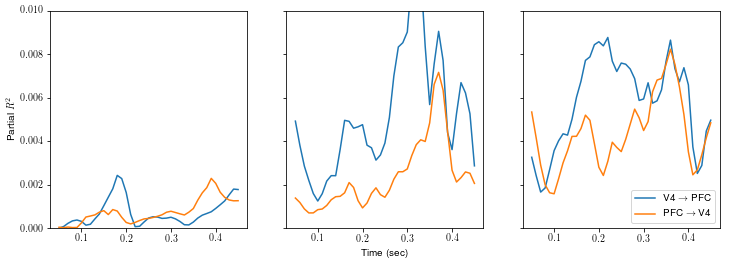

In [29]:
#figure showing information flow by partial R^2 in the appendix
from scipy import ndimage
from scipy import ndimage
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,4))

for f, (ax, s0) in enumerate(zip(axes, Rho[indices])):
    bt = 1 #pick which time you like to start calculation
    ss1 = np.ones(num_time)
    ss2 = np.ones(num_time)
    pss1 = np.ones(num_time)
    pss2 = np.ones(num_time)
    times = np.arange(num_time)
    cross = s0[:num_time, num_time:]
    for i in range(bt, num_time):
        Syy1 = s0[i,i]
        Syy2 = s0[i+num_time, i+num_time]
        sxx = []
        inds = np.array([h for h in range(i)] + [h+num_time for h in range(i)])
        for ii in inds:
            for jj in inds:
                sxx.append(s0[jj,ii])
        Sxx = np.array(sxx).reshape((len(inds), len(inds)))
        Sxy1 = s0[inds,i][:,None]
        Sxy2 = s0[inds,i+num_time][:,None]
        ss1[i] = Syy1 - Sxy1.transpose((1,0))@np.linalg.inv(Sxx)@Sxy1
        ss2[i] = Syy2 - Sxy2.transpose((1,0))@np.linalg.inv(Sxx)@Sxy2

        #now only consider inside
        pSxx1 = s0[:i, :i]
        pSxx2 = s0[num_time:(num_time+i), num_time:(num_time+i)]
        pSxy1 = s0[:i,i][:,None]
        pSxy2 = s0[num_time:(num_time+i),i+num_time][:,None]
        pss1[i] = Syy1 - pSxy1.transpose((1,0))@np.linalg.inv(pSxx1)@pSxy1
        pss2[i] = Syy2 - pSxy2.transpose((1,0))@np.linalg.inv(pSxx2)@pSxy2

    sigma = 2.5
    lead_lag1 = (pss1-ss1)/pss1
    lead_lag2 = (pss2-ss2)/pss2
    x_g1d = times # ndimage.gaussian_filter1d(times, sigma)
    y_g1d1 = lead_lag1 # ndimage.gaussian_filter1d(lead_lag1, sigma)
    y_g1d2 = lead_lag2 # ndimage.gaussian_filter1d(lead_lag2, sigma)
    # plt.figure(figsize=(4,6))
    # plt.rcParams.update({'font.size': 28})
    tt = np.arange(5, num_time-5, 1)
    
    ax.plot(x_g1d[tt]*0.01,y_g1d2[tt], label=r"V4 $\rightarrow$ PFC")
    ax.plot(x_g1d[tt]*0.01,y_g1d1[tt], label=r"PFC $\rightarrow$ V4")
    # ax.axhline(y=0, color='black', linewidth=1)
    #plt.legend(['V4-PFC', 'PFC-V4'])
    #plt.xlabel('time(ms)')
    #plt.ylabel('Partial R2')
    ax.set_ylim([0.00,0.01])
    # ax.set_xlim([0, 0.5])
ax.legend()
    
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
plt.ylim([0.00,0.01])
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Time (sec)")
plt.ylabel(r"Partial $R^2$")